In [31]:
from fastai.tabular.all import *
from transfertab.utils import *
from transfertab.transfer import *
from transfertab.extract import *
from fastcore.xtras import *
from fastai.learner import *
import torch
import numpy as np
from fastai.interpret import *
import wandb
from fastai.callback.wandb import *

In [32]:
df = pd.read_csv("../data/datasets/online_shoppers_intention.csv")

In [33]:
df.shape[0]*0.6

7398.0

In [34]:
dfA = df.iloc[0:7398]
dfB = df.iloc[7398:-1]

In [35]:
dfA.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [36]:
dfA.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [37]:
len(dfA.ProductRelated.unique())

221

In [38]:
catcolsA = ['Administrative', 'Informational',
       'ProductRelated',
       'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend']
contcolsA = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues']
target='Revenue'

In [39]:
splitsA = RandomSplitter(valid_pct=0.01)(range_of(dfA))
splitsA

((#7325) [5295,3011,3944,4591,613,378,1347,6118,5232,3122...],
 (#73) [6626,2765,4524,4360,6964,6374,7275,1478,628,5787...])

In [40]:
toA = TabularPandas(dfA, procs=[Categorify, FillMissing, Normalize],
                   cat_names=catcolsA,
                   cont_names=contcolsA,
                   y_names=target,
                   splits=splitsA)
dlsA = toA.dataloaders(bs=512)
rocaucbinA = RocAucBinary()
learnA = tabular_learner(dlsA, metrics=[rocaucbinA, accuracy])

In [80]:
splitsB = RandomSplitter(valid_pct=0.2)(range_of(dfB))
toB = TabularPandas(dfB, procs=[Categorify, FillMissing, Normalize],
                   cat_names = catcolsA,
                   cont_names = contcolsA,
                   y_names=target,
                   splits=splitsB)
dlsB = toB.dataloaders(bs=512)

In [81]:
splitsB

((#3945) [3241,2131,3131,715,2367,3075,2512,3649,1067,1579...],
 (#986) [3459,424,2542,4375,3654,959,4726,2884,29,699...])

In [42]:
wandb.init(
    project='Experiments', 
    save_code=True, 
    group='Exp5c', 
    job_type='pretrain', 
    tags=['base', 'shopping', 'revenue', 'modelA'], 
    name='modelA training',
    notes="Training modelA from which we'll take embeddings",
    reinit=True,
    dir='/Users/manikyabardhan/Documents/github/transfertab/experiments/results/exp5c',
    entity='transfertab'
)

wandb: ERROR Control-C detected -- Run data was not synced


wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [43]:
dlsB.train

In [44]:
cbs=[WandbCallback(valid_dl = dlsB.train,log_preds=False, log="all", dataset_name="online_shoppers_intention (first .6)", n_preds=0, seed=1), SaveModelCallback()]
learnA.fit_one_cycle(30, cbs=cbs)

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.971079,0.767588,0.299180,0.273973,00:00
1,0.836445,0.749948,0.887978,0.191781,00:00
2,0.731603,0.613882,0.953552,0.863014,00:00
3,0.659418,0.494095,0.963115,0.945205,00:00
4,0.607370,0.419885,0.969945,0.917808,00:00
5,0.562197,0.390636,0.976776,0.904110,00:00
6,0.521472,0.362562,0.959016,0.890411,00:00
7,0.483065,0.319190,0.954918,0.904110,00:00
8,0.443694,0.318054,0.964481,0.904110,00:00
9,0.404357,0.299453,0.968579,0.890411,00:00


Better model found at epoch 0 with valid_loss value: 0.7675877213478088.
Better model found at epoch 1 with valid_loss value: 0.7499479651451111.
Better model found at epoch 2 with valid_loss value: 0.6138821244239807.
Better model found at epoch 3 with valid_loss value: 0.4940950572490692.
Better model found at epoch 4 with valid_loss value: 0.41988468170166016.
Better model found at epoch 5 with valid_loss value: 0.39063602685928345.
Better model found at epoch 6 with valid_loss value: 0.3625620901584625.
Better model found at epoch 7 with valid_loss value: 0.31919002532958984.
Better model found at epoch 8 with valid_loss value: 0.3180544972419739.
Better model found at epoch 9 with valid_loss value: 0.29945266246795654.
Better model found at epoch 11 with valid_loss value: 0.2793370485305786.
Better model found at epoch 12 with valid_loss value: 0.2768273949623108.
Better model found at epoch 13 with valid_loss value: 0.2728751599788666.
Better model found at epoch 14 with valid_lo

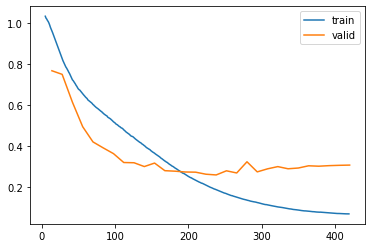

In [45]:
learnA.recorder.plot_loss()

In [47]:
torch.save(learnA.model.state_dict(),"../experiments/results/exp5c/modelA_state_dict")

In [49]:
catdictA = {col:list(learnA.dls.categorify.classes[col]) for col in catcolsA}

In [76]:
type(learnA.dls.categorify.classes['Administrative'][1])

numpy.int8

In [77]:
embeds = extractembeds(learnA.model, catdictA, transfercats=catcolsA, allcats=catcolsA)

In [78]:
wandb.finish()

epoch,30
train_loss,0.06825
raw_loss,0.06484
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
_runtime,101
_timestamp,1635769929
_step,419


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▇▅▅▅▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [82]:
dlsB

In [83]:
rocaucbinB = RocAucBinary()
learnB = tabular_learner(dlsB, metrics=[rocaucbinB, accuracy])

In [89]:
# catdict = getcatdict(df, catcolsA)
# metadict = {}
# for (cat, classes) in catdict.items():
# 	metadict[cat] = {'mapped_cat': cat, 'classes_info': {str(clas): str(clas) for clas in classes}}
# with open('../data/jsons/shoppers-intention.json', 'w') as fp:
# 	json.dump(metadict, fp)

In [103]:
with open('../data/jsons/shoppers-intention.json', 'r') as fp:
    metadict = json.load(fp) 

In [104]:
metadict

{'Administrative': {'mapped_cat': 'Administrative',
  'classes_info': {'0': '0',
   '1': '1',
   '2': '2',
   '4': '4',
   '12': '12',
   '3': '3',
   '10': '10',
   '6': '6',
   '5': '5',
   '9': '9',
   '8': '8',
   '16': '16',
   '13': '13',
   '11': '11',
   '7': '7',
   '18': '18',
   '14': '14',
   '17': '17',
   '19': '19',
   '15': '15',
   '24': '24',
   '22': '22',
   '21': '21',
   '20': '20',
   '23': '23',
   '27': '27',
   '26': '26'}},
 'Informational': {'mapped_cat': 'Informational',
  'classes_info': {'0': '0',
   '1': '1',
   '2': '2',
   '4': '4',
   '16': [],
   '5': '5',
   '3': '3',
   '14': [],
   '6': '6',
   '12': '12',
   '7': '7',
   '9': '9',
   '10': '10',
   '8': '8',
   '11': '11',
   '24': []}},
 'ProductRelated': {'mapped_cat': 'ProductRelated',
  'classes_info': {'1': '1',
   '2': '2',
   '10': '10',
   '19': '19',
   '0': '0',
   '3': '3',
   '16': '16',
   '7': '7',
   '6': '6',
   '23': '23',
   '13': '13',
   '20': '20',
   '8': '8',
   '5': '5',
 

In [91]:
learnA.model.embeds

ModuleList(
  (0): Embedding(25, 10)
  (1): Embedding(17, 8)
  (2): Embedding(219, 33)
  (3): Embedding(7, 5)
  (4): Embedding(10, 6)
  (5): Embedding(9, 5)
  (6): Embedding(13, 7)
  (7): Embedding(10, 6)
  (8): Embedding(21, 9)
  (9): Embedding(4, 3)
  (10): Embedding(3, 3)
)

In [106]:
learnB.dls.cat_names[3]

'SpecialDay'

In [ ]:
learnB.dls.categorify['']

In [100]:
len(set(learnB.dls.categorify['ProductRelated']) - set(learnA.dls.categorify['ProductRelated']))

77

In [105]:
for clas in set(learnB.dls.categorify['ProductRelated']) - set(learnA.dls.categorify['ProductRelated']):
    metadict['ProductRelated']['classes_info'][clas] = []

In [ ]:
learnA.dls.categorify['ProductRelated']

In [92]:
learnB.model.embeds

ModuleList(
  (0): Embedding(25, 10)
  (1): Embedding(14, 7)
  (2): Embedding(260, 36)
  (3): Embedding(2, 2)
  (4): Embedding(8, 5)
  (5): Embedding(9, 5)
  (6): Embedding(13, 7)
  (7): Embedding(10, 6)
  (8): Embedding(14, 7)
  (9): Embedding(4, 3)
  (10): Embedding(3, 3)
)